# Sea level for current year

This notebook computes the preliminary mean sea level. This notebook is part of the validation of the official [sea-level monitor](https://nbviewer.ipython.org/github/openearth/sealevel/blob/master/notebooks/dutch-sea-level-monitor.ipynb) for the Dutch coast. The official figures are not available until Rijkswaterstaat delivers data to the [PSMSL](http://www.psmsl.org) (often in june, and on request). Here we compute the mean for what is called the [metric](http://www.psmsl.org/data/obtaining/metric.php) data, that means uncorrected for changes in the tide gauge benchmark. The official sea-level rise figures use the [Revised Local Reference](http://www.psmsl.org/data/obtaining/rlr.php) figures. The information on the validation of previous years can be found in the [paired difference](https://nbviewer.ipython.org/github/openearth/sealevel/blob/master/notebooks/validation/paired%20difference%20analysis%20RWS%20and%20PSMSL.ipynb) analysis. 

To run this notebook please download the data using the makefiles in data/psmsl and data/waterbase. The current sea-level rise depends on the official mean and on the wind data from the NCAR [NCEP](https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.html) reanalysis (available a few days after each month). The data for the last few years are compared to the PSMSL data. We use the metric data in this notebook as the RLR version is part of the validation for the final figures.

In [1]:
# builtin modules
import json
import logging
import datetime 
import io
import pathlib

# numeric 
import numpy as np
import pandas as pd
import netCDF4

# downloading data
import requests

# timezones
from dateutil.relativedelta import relativedelta
import pytz

# progress
from tqdm import tqdm_notebook as tqdm

# plotting
import matplotlib.dates 
import matplotlib.pyplot as plt

# tide
import utide


# for interactive charts
from ipywidgets import interact

%matplotlib inline

# create a logger
logger = logging.getLogger('notebook')

In [2]:
# note that there are two stations for IJmuiden.
# The station was moved from the sluices to outside of the harbor in 1981.
ids = ['DELFZL', 'DENHDR', 'HARLGN', 'HOEKVHLD', 'IJMDBTHVN', 'VLISSGN']
names = {
    'DELFZL': 'Delfzijl',
    'DENHDR': 'Den Helder',
    'HARLGN': 'Harlingen',
    'HOEKVHLD': 'Hoek van Holland',
    'IJMDBTHVN': 'IJmuiden',
    'VLISSGN': 'Vlissingen'
}
# ids from http://www.psmsl.org/data/obtaining/
psmsl_ids = {
    'DELFZL': 24, 
    'DENHDR': 23, 
    'HARLGN': 25, 
    'HOEKVHLD': 22,
    'IJMDBTHVN': 32, 
    'VLISSGN': 20
    
}
current_year = 2017
# fill in the format later
path = str(
    pathlib.Path('~/src/sealevel/data/waterbase/{station}-{year}.txt').expanduser()
)


storm_surge_reports = [
    {
        'date': datetime.datetime(2017, 1, 14),
        'url': 'https://waterberichtgeving.rws.nl/water-en-weer/verwachtingen-water/water-en-weerverwachtingen-waternoordzee/stormvloedrapportages/stormvloedverslagen/download:782'
    },
    {
        'date': datetime.datetime(2017, 10, 29),
        'url': 'https://waterberichtgeving.rws.nl/water-en-weer/verwachtingen-water/water-en-weerverwachtingen-waternoordzee/stormvloedrapportages/stormvloedverslagen/download:994'
    }
]


## Stations
You can change the year below and confirm the id's of the stations. These stations are considered the "main stations". They all have a long running history (>100 years) and are spread out somewhat evenly along the Dutch coast. For details of each tide gauge, please consult the [tide gauge overview](https://nbviewer.ipython.org/github/openearth/sealevel/blob/master/notebooks/dutch-tide-gauges.ipynb). 


Here we read all the files, downloaded from [waterbase](http://live.waterbase.nl), the old source from Rijkswaterstaat, connected to DONAR. The official source ([Data Distributie Laag](https://www.rijkswaterstaat.nl/rws/opendata/DistributielaagWebservices-SUM-2v7.pdf)) is not functioning properly as data is missing since june last year (sent issue to servicedesk data). 
Here we only do a missing and value domain check. Quality flags are not available in the waterbase export and a detailed analysis of trend breaks, consistency between measurements is done in the official validation. 

In [3]:
# create a list of records
records = []
# for each station
for station in ids:
    # look back a few years for consistency (from-through)
    for year in range(current_year-2, current_year + 1):
        df = pd.read_csv(path.format(station=station, year=year), skiprows=3, sep=';')
        # there should be no missings
        assert df['waarde'].isna().sum() == 0
        # all values should be within this range
        # if not check what's happening
        assert df['waarde'].min() > -400
        assert df['waarde'].max() < 600
        # and check the units
        assert (df['eenheid'] == 'cm').all()

        mean = df['waarde'].mean()
        records.append({
            'station': station,
            'year': year,
            'mean': mean
        })
        


## Compare stations
Don't expect that all stations have the same mean sea level. Delfzijl [traditionaly](https://nbviewer.ipython.org/github/openearth/sealevel/blob/master/notebooks/dutch-sea-level-monitor.ipynb#Regional-variability) has the highest mean sea-level, followed by Harlingen. Hoek van Holland has been rising for several years, due to local subsidence. Den Helder and Vlissingen traditionaly have the lowest sea-level. 

In [4]:
# merge all the records to get a list of mean sea level per year
latest_df = pd.DataFrame(records)
# check the mean for 2017
latest_df.set_index(['station', 'year']) 

mean
station   year           
DELFZL    2015  17.914897
          2016  14.388020
          2017  19.950985
DENHDR    2015   3.628919
          2016   1.770723
          2017   5.541436
HARLGN    2015  14.044711
          2016  10.011778
          2017  14.616878
HOEKVHLD  2015  10.940183
          2016  10.787222
          2017  13.146691
IJMDBTHVN 2015   6.458467
          2016   5.706721
          2017   8.634249
VLISSGN   2015   2.690887
          2016   2.724615
          2017   3.945041

## Detailed analysis

Here we look at the timeseries in Detail to make sure that there are no outliers. All data is already gap-filled and checked for outliers in the validation steps before data is entered into DONAR. 
Things to check for: 
- make sure that the highest values correspond to known storms
- check for monthly signal [spring/neap](https://oceanservice.noaa.gov/facts/springtide.html) cycle (twice per month) 
- consistent signal


In [5]:
# read the latest data 
sources = {}
for station in ids:
    df = pd.read_csv(path.format(station=station, year=current_year), skiprows=3, sep=';')
    df['date'] = pd.to_datetime(df['datum'] + ' ' + df['tijd'])
    # Several stations contain duplicates, drop them and keep the first
    # Not sure why.... (contact RWS)
    df = df.drop_duplicates(keep='first')
    # there should be no missings
    assert df['waarde'].isna().sum() == 0
    # all values should be within this range
    # if not check what's happening
    assert df['waarde'].min() > -400
    assert df['waarde'].max() < 600
    # and check the units
    assert (df['eenheid'] == 'cm').all()
    sources[station] = df



In [6]:
# this is the data, a bit verbose but the relevant things are datum tijd and waarde
df = sources[ids[0]].set_index('date')
# make sure the dataset is complete until (almost) end of the year
df.tail()

,locatie,waarnemingssoort,datum,tijd,bepalingsgrenscode,waarde,eenheid,hoedanigheid,anamet,ogi,vat,bemhgt,refvlk,EPSG,x/lat,y/long,orgaan,"biotaxon (cijfercode,biotaxon omschrijving,biotaxon Nederlandse naam)"
date,,,,,,,,,,,,,,,,,,
2017-12-30 00:56:00,Delfzijl,Waterhoogte in cm t.o.v. normaal amsterdams pe...,2017-12-30,00:56,NaN,-103,cm,T.o.v. Normaal Amsterdams Peil,Rek. gem. waterhoogte over vorige 5 en volgend...,Nationaal,Vlotterniveaumeter - type DNM,NVT,NVT,7415,258000,594430,NVT,"NVT,NVT,Niet van toepassing"
2017-12-30 00:57:00,Delfzijl,Waterhoogte in cm t.o.v. normaal amsterdams pe...,2017-12-30,00:57,NaN,-104,cm,T.o.v. Normaal Amsterdams Peil,Rek. gem. waterhoogte over vorige 5 en volgend...,Nationaal,Vlotterniveaumeter - type DNM,NVT,NVT,7415,258000,594430,NVT,"NVT,NVT,Niet van toepassing"
2017-12-30 00:58:00,Delfzijl,Waterhoogte in cm t.o.v. normaal amsterdams pe...,2017-12-30,00:58,NaN,-104,cm,T.o.v. Normaal Amsterdams Peil,Rek. gem. waterhoogte over vorige 5 en volgend...,Nationaal,Vlotterniveaumeter - type DNM,NVT,NVT,7415,258000,594430,NVT,"NVT,NVT,Niet van toepassing"
2017-12-30 00:59:00,Delfzijl,Waterhoogte in cm t.o.v. normaal amsterdams pe...,2017-12-30,00:59,NaN,-106,cm,T.o.v. Normaal Amsterdams Peil,Rek. gem. waterhoogte over vorige 5 en volgend...,Nationaal,Vlotterniveaumeter - type DNM,NVT,NVT,7415,258000,594430,NVT,"NVT,NVT,Niet van toepassing"
2017-12-30 01:00:00,Delfzijl,Waterhoogte in cm t.o.v. normaal amsterdams pe...,2017-12-30,01:00,NaN,-107,cm,T.o.v. Normaal Amsterdams Peil,Rek. gem. waterhoogte over vorige 5 en volgend...,Nationaal,Vlotterniveaumeter - type DNM,NVT,NVT,7415,258000,594430,NVT,"NVT,NVT,Niet van toepassing"


# Tide
Here we seperate the tide. The official tidal computation is based on HATYAN, but that is not publicly available. So here we use the python version of [UTide](http://www.po.gso.uri.edu/~codiga/utide/utide.htm). This is just a basic ordinary least squares decomposition using an automated selection of constituents. In general the handpicked selection has a higher external validaty (predicts better). Our main concern here to seperate storm-surge and tide. 

In [7]:
tides = {}
coefs = {}
for station, df in sources.items():
    # use date as an index (so we have a datetime index)
    df = df.set_index('date')
    t = matplotlib.dates.date2num(df.index.to_pydatetime())
    coef = utide.solve(
        t, 
        df['waarde'].values, # numpy array
        lat=52, # for the equilibrium nodal tide
        method='ols', # just use linear model
        conf_int='linear'
    )
    coefs[station] = coef
    tide = utide.reconstruct(t, coef)
    tides[station] = tide
    

solve: matrix prep ... solution ... diagnostics ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... diagnostics ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... diagnostics ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... diagnostics ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... diagnostics ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... diagnostics ... done.
prep/calcs ... done.


In [8]:
for station, df in sources.items():
    tide = tides[station]
    # update dataframe (inline)   
    df['tide'] = tide['h']
    df['surge'] = df['waarde'] - df['tide']

## Maximum water levels
We can now compute the maximum water levels for each station. This is most likely to occur during the combination of high tide and a storm surge.
You can often find some detailed information about an event using the [storm reports](https://waterberichtgeving.rws.nl/water-en-weer/verwachtingen-water/water-en-weerverwachtingen-waternoordzee/stormvloedrapportages/stormvloedverslagen) of the SVSD. 
You can lookup the return periods using the [coastal forcings](https://www.helpdeskwater.nl/publish/pages/132669/1230087-002-hye-0001-v4-r-hydraulische_belastingen_kust_def3.pdf) document from WBI. 

In [9]:
# compute the maximum water levels
records = []
for station, df in sources.items():
    date_df = df.set_index('date')
    
    max_date = date_df['waarde'].idxmax()
    record = {
        'station': station, 
        'date': max_date, 
        'value': date_df['waarde'].loc[max_date]
    }
    records.append(record)
annual_maxima_df = pd.DataFrame(records)
annual_maxima_df

,date,station,value
0,2017-01-14 00:23:00,DELFZL,394
1,2017-01-13 19:58:00,DENHDR,213
2,2017-01-13 21:33:00,HARLGN,299
3,2017-12-08 05:58:00,HOEKVHLD,238
4,2017-01-13 16:20:00,IJMDBTHVN,237
5,2017-01-14 02:54:00,VLISSGN,336


# Maximum surge
We can also compute the maximum surge levels for each station. The surge is the water level minus the astronomical tide. These dates will be different from the table above because a high water level is more likely to occur during high tide.


In [10]:
# compute the maximum surge
records = []
for station, df in sources.items():
    df = df.drop_duplicates(['date'])
    date_df = df.set_index('date')
    
    max_date = date_df['surge'].idxmax()
    record = {
        'station': station, 
        'date': max_date, 
        'surge': date_df['surge'].loc[max_date]
    }
    records.append(record)
annual_maxima_surge_df = pd.DataFrame(records)
annual_maxima_surge_df



,date,station,surge
0,2017-01-14 00:02:00,DELFZL,246.833348
1,2017-01-12 00:16:00,DENHDR,162.689125
2,2017-01-13 21:33:00,HARLGN,208.862456
3,2017-01-14 00:38:00,HOEKVHLD,170.786806
4,2017-01-14 01:20:00,IJMDBTHVN,178.048087
5,2017-01-13 23:37:00,VLISSGN,191.822315


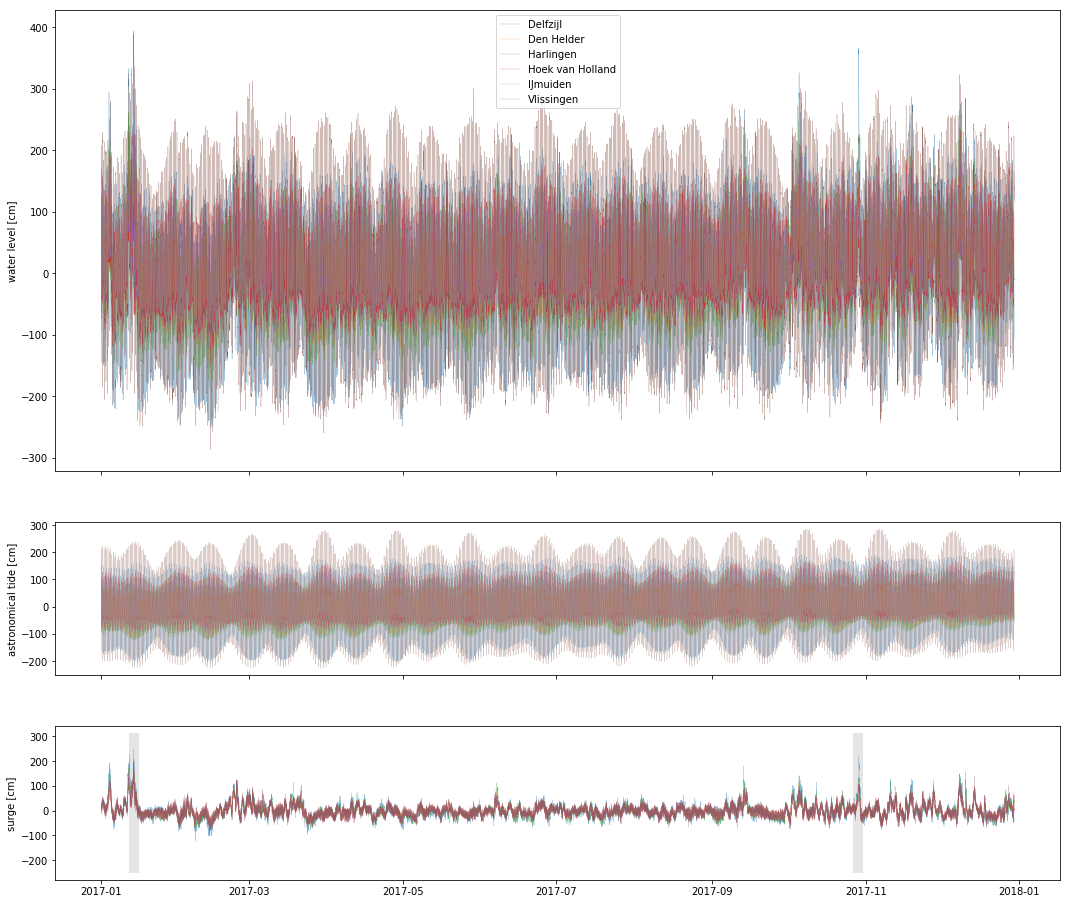

In [11]:
fig, axes = plt.subplots(
    # 2 rows, 1 column
    3, 1, 
    # big
    figsize=(18, 16), 
    # focus on tide
    gridspec_kw=dict(height_ratios=[3, 1, 1]),
    sharex=True
)
for station, df in sources.items():
    index = df.set_index('date').index
    axes[0].plot(index.to_pydatetime(), df['waarde'], '-', label=names[station], linewidth=0.2)
    axes[1].plot(index.to_pydatetime(), df['tide'], '-', label=station, alpha=0.5, linewidth=0.3)
    axes[2].plot(index.to_pydatetime(), df['surge'], '-', label=station, alpha=0.5, linewidth=0.3)
axes[0].legend(loc='best');
axes[0].set_ylabel('water level [cm]')
axes[1].set_ylabel('astronomical tide [cm]')
axes[2].set_ylabel('surge [cm]')
for event in storm_surge_reports:
    axes[2].fill_between(
        [event['date'] + datetime.timedelta(hours=-48), event['date'] + datetime.timedelta(hours=48)],
        y1=axes[1].get_ylim()[0],
        y2=axes[1].get_ylim()[1],
        alpha=0.1,
        facecolor='black'
    )

## Detailed view
Use the interactive plot below to look at the timeseries in detail. You can drag to have a look at each week. 
It is normal to see some high frequency patterns and to see some tidal residu. 

In [12]:
# plot a window of a week

def plot(weeks=(0, 51)):
    
    fig, axes = plt.subplots(
        # 2 rows, 1 column
        3, 1, 
        # big
        figsize=(12, 8), 
        # focus on tide
        gridspec_kw=dict(height_ratios=[3, 1, 1]),
        sharex=True
    )
    for station, df in sources.items():
        selected = df[
            np.logical_and(
                df['date'] >= datetime.datetime(2017, 1, 1) + datetime.timedelta(weeks=weeks),
                df['date'] < datetime.datetime(2017, 1, 1) + datetime.timedelta(weeks=weeks + 1)
            )
        ]
        index = selected.set_index('date').index
        axes[0].plot(index.to_pydatetime(), selected['waarde'], '-', label=names[station], alpha=0.5, linewidth=2)
        axes[1].plot(index.to_pydatetime(), selected['tide'], '-', label=station, alpha=0.5, linewidth=2)
        axes[2].plot(index.to_pydatetime(), selected['surge'], '-', label=station, alpha=0.5, linewidth=2)
    axes[0].legend(loc='best');
    axes[0].set_ylabel('water level [cm]')
    axes[1].set_ylabel('astronomical tide [cm]')
    axes[2].set_ylabel('surge [cm]')
    axes[0].set_ylim(-300, 500)
    axes[1].set_ylim(-250, 250)
    axes[2].set_ylim(-100, 300)

interact(plot);

interactive(children=(IntSlider(value=25, description='weeks', max=51), Output()), _dom_classes=('widget-interact',))

## Integration with PSMSL
Check the latest data with that of the PSMSL. There are some known differences because the data delivered to PSMSL is based on hourly data. Here we analyse the data of every minute. In general they should be within about a cm difference.


In [13]:
# now get the PSMSL data for comparison
psmsls = {}

# TODO: read the zip file
for station, id_ in psmsl_ids.items():
    df = pd.read_csv(io.StringIO(requests.get('http://www.psmsl.org/data/obtaining/met.monthly.data/{}.metdata'.format(
        id_
    )).text), sep=';', names=[
        'year', 'level', 'code', 'quality'
    ])
    df['year'] = df.year.apply(lambda x: np.floor(x).astype('int'))
    df['station'] = station
    psmsls[station] = df
psmsl_df = pd.concat(psmsls.values())
# compute sea level in cm
psmsl_df['sea_level'] = psmsl_df['level'] / 10

In [14]:
# compare data to metric data
# some differences exist
# see HKV report from 2017 on this topic 
# most differences are due to that I think hourly measurements are used for the psmsl mean
for station, df in psmsls.items():
    print(station)
    annual_df = df[['year', 'level']].groupby('year').mean()
    print(annual_df.tail(n=5))
    new_records = latest_df[np.logical_and(
        latest_df.station == station, 
        np.isin(latest_df.year, (2015, 2016, 2017))
    )]
    print(new_records)
    

DELFZL
           level
year            
2012  104.750000
2013   81.250000
2014  125.166667
2015  177.916667
2016  144.500000
        mean station  year
0  17.914897  DELFZL  2015
1  14.388020  DELFZL  2016
2  19.950985  DELFZL  2017
DENHDR
          level
year           
2012   0.833333
2013 -27.916667
2014   5.750000
2015  35.416667
2016  17.666667
       mean station  year
3  3.628919  DENHDR  2015
4  1.770723  DENHDR  2016
5  5.541436  DENHDR  2017
HARLGN
           level
year            
2012   82.166667
2013   39.166667
2014   92.416667
2015  139.333333
2016  103.833333
        mean station  year
6  14.044711  HARLGN  2015
7  10.011778  HARLGN  2016
8  14.616878  HARLGN  2017
HOEKVHLD
           level
year            
2012   84.916667
2013   69.666667
2014  100.166667
2015  108.583333
2016  111.583333
         mean   station  year
9   10.940183  HOEKVHLD  2015
10  10.787222  HOEKVHLD  2016
11  13.146691  HOEKVHLD  2017
IJMDBTHVN
          level
year           
2012  26.583333
201

In [15]:
# mean sealevel from psmsl
mean_df = psmsl_df[['year', 'sea_level']].groupby('year').mean()

In [16]:
mean_df.loc[current_year] = latest_df[latest_df['year'] == current_year]['mean'].mean()


## Top 10
This shows the highest annual mean sea levels since we started measuring. One would expect every year to be higher than the previous, but not all years have storm surges (for example, no storm surges from 2009 and through 2012). 
And the nodal tide also makes it more likely that high annual means occur during higher nodal tide. 


In [17]:
# show the top 10 of highest sea levels
mean_df.sort_values('sea_level', ascending=False).head(n=10)

,sea_level
year,
2017,10.972547
2007,9.427778
2015,9.184722
1998,8.275000
2004,8.169444
2001,7.923611
1999,7.829167
2016,7.769444
1990,7.476389


## Nodal tide
The nodal tide causes a variation with an amplitude of about 1cm. This makes it more likely that higher means occur during the upper cycle. The analysis below shows in which part of the cycle we are.


In [18]:
# Use the fitted values from the sea-level monitor (note that these are RLR not in NAP)
years = mean_df.index[mean_df.index > 1890]
# use the model without wind (otherwise the intercept does not match up)
fitted = (
    1.9164 * (years - 1970)  + 
    -25.7566  +
    7.7983 * np.cos(2*np.pi*(years-1970)/18.613) +
    -10.5326 * np.sin(2*np.pi*(years-1970)/18.613)  
)


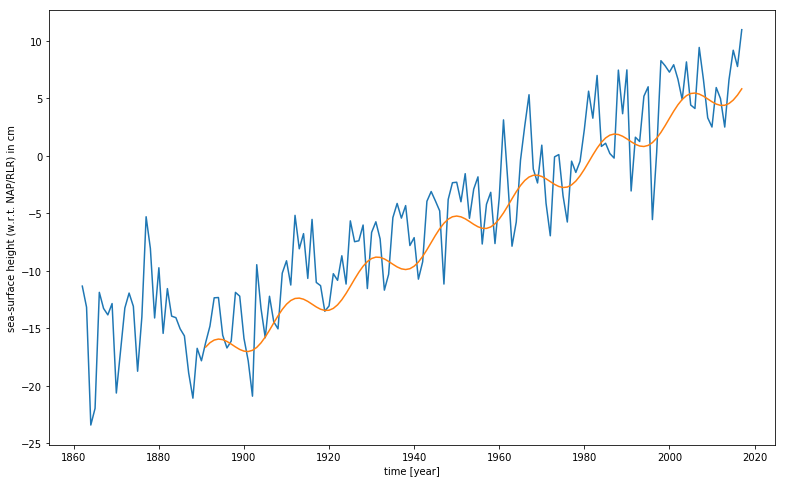

In [19]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(mean_df.index, mean_df['sea_level'])
ax.plot(years, fitted/10)
ax.set_ylabel('sea-surface height (w.r.t. NAP/RLR) in cm')
ax.set_xlabel('time [year]');


In [20]:
# find the maximum sea-level
mean_df.idxmax()

sea_level    2017
dtype: int64

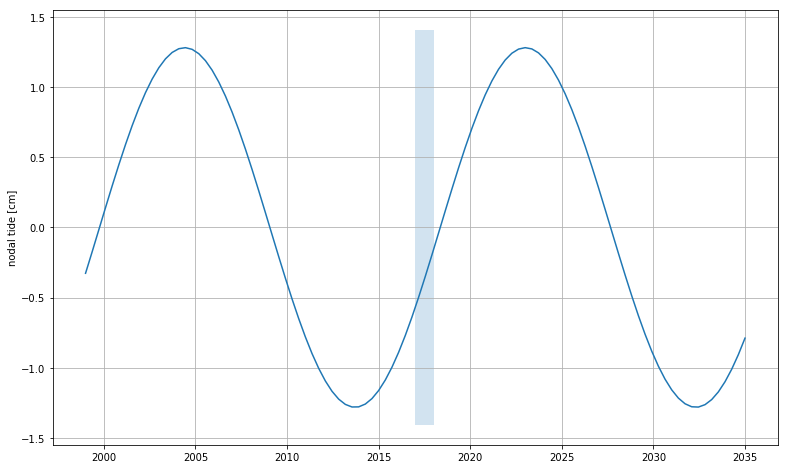

In [21]:
# check the current phase of nodal tide, u,v from sea-level monitor (full model)
tau = np.pi * 2
t = np.linspace(current_year - 18, current_year + 18, num=100)
nodal_tide = 7.5367*np.cos(tau*(t - 1970)/18.6) + -10.3536*np.sin(tau*(t - 1970)/18.6) 
amplitude = np.sqrt(7.5367**2 + (-10.3536)**2)

fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(t, nodal_tide/10);
ax.set_ylabel('nodal tide [cm]')
ax.fill_between([2017, 2018], *ax.get_ylim(), alpha=0.2)
ax.grid('on')


In [22]:
# next peak of nodal tide
2004.5 + 18.6

2023.1